#Reconstructing Images from Brain Activity


> Mohammed Alsiraji



Images dataset file 'subj03_images.npy'

https://drive.google.com/file/d/1wNh_EstCoNMQhRXbkbnCvy-SWMSBmFzW/view?usp=sharing

Decoder file 'fmri_decoder_subj03rhV3.pth'

https://drive.google.com/file/d/1id9tqPkeRS298SdqWuBgqxcwZWeix0Hc/view?usp=sharing

## Related Libraries

In [ ]:
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
root_dir = '/content/drive/MyDrive/DNNLS/Assessment'

algonauts_dir = 'algonauts_2023_tutorial_data' # Path to the shortcut in your drive
reduced_images_dir = 'reduced_images_algonauts' # Path to the shortcut in your drive

Mounted at /content/drive/


##Helper Functions

In [ ]:
def load_fmri_of_subject( subj, hemisphere, directory = root_dir ):
  subj = subj # Subject
  hemisphere = hemisphere # Which side of the brain
  # Listing directory
  subj = format(subj, '02')
  data_dir = os.path.join(directory, algonauts_dir )
  data_dir = os.path.join(data_dir, 'subj' + subj) # subj01
  fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri') # Location the brain activation
  # Here we load the data
  if hemisphere == 'left':
    brain_activity = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
  else:
    brain_activity = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))
  return brain_activity
def load_reduced_image_subject(img, directory = root_dir ):
  image = reduced_images[img]
  return Image.fromarray(image)


def showImage( ax, image, title = '' ):
  ''' This is a helper function that allows you to show the results of your training '''
  image = (image - torch.min(image))/(torch.max(image)-torch.min(image)) # image 0...1
  ax.imshow(image.permute(1,2,0)) # You need reorganize the dimension (3, H,  W) -> (H, W, 3)
  ax.set_title(title)

def calculate_mse(original, reconstructed):
    mse = torch.mean(torch.square(original - reconstructed))
    return mse.item()

def calculate_ssim(original, reconstructed):
    # Convert tensors to numpy arrays
    original_np = original.detach().cpu().numpy().transpose(1, 2, 0)  # Remove batch dimension
    reconstructed_np = reconstructed.detach().cpu().numpy().transpose(1, 2, 0)  # Remove batch dimension

    # Calculate SSIM
    ssim_value = ssim(original_np, reconstructed_np, multichannel=True)
    return ssim_value

def img_similarity(org_img, rec_img):
    # Calculate MSE
    mse = calculate_mse(org_img, rec_img)
    # print("Mean Squared Error (MSE):", mse)

    # Calculate SSIM
    ssim_value = calculate_ssim(org_img, rec_img)
    # print("Structural Similarity Index (SSIM):", ssim_value)
    return mse , ssim_value


##Dataset

In [ ]:
# Loading reduced images
reduced_images = np.load('/content/drive/MyDrive/DNNLS/Assessment/subj03_images.npy')

In [ ]:
#@title This dataset provides batches of image, brain activity, pairs from subject 3 right hemisphere
class BrainDataSet(Dataset):
  def __init__( self, subject, hemisphere, transform = None ):
    self.subject = subject # We need to select a particular object
    self.hemisphere = hemisphere
    self.fmri_data = load_fmri_of_subject( subject, hemisphere ) # Load all the data from the subjects
    self.data_len, self.num_samples = self.fmri_data.shape # Get the shape MxN
    self.transform = transform

  def __len__(self):
    return self.data_len # len is the total number of images

  def __getitem__( self, idx ):
    # Get FMRI data
    x = self.fmri_data[idx, :]
    # Obtain images
    img = load_reduced_image_subject(img = idx ) # This is slow. If you can you should preload all images
    return self.transform(img) if self.transform else img, torch.from_numpy(x),


subject = 3 # change this to change the subject
hemisphere = 'right'

resize_normalize = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.Resize((128,128)), # We downsample the images a lot. Bigger images take more time to train
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

# Create the dataset
myDataset = BrainDataSet( subject, hemisphere, resize_normalize)

train_loader = DataLoader( dataset = myDataset,
                          #  num_workers = 2, # Parallel to make it faster
                          #  prefetch_factor=16, # This is used to preload some of the data
                           batch_size = 32,
                           shuffle = True )

###Dataset Exploration

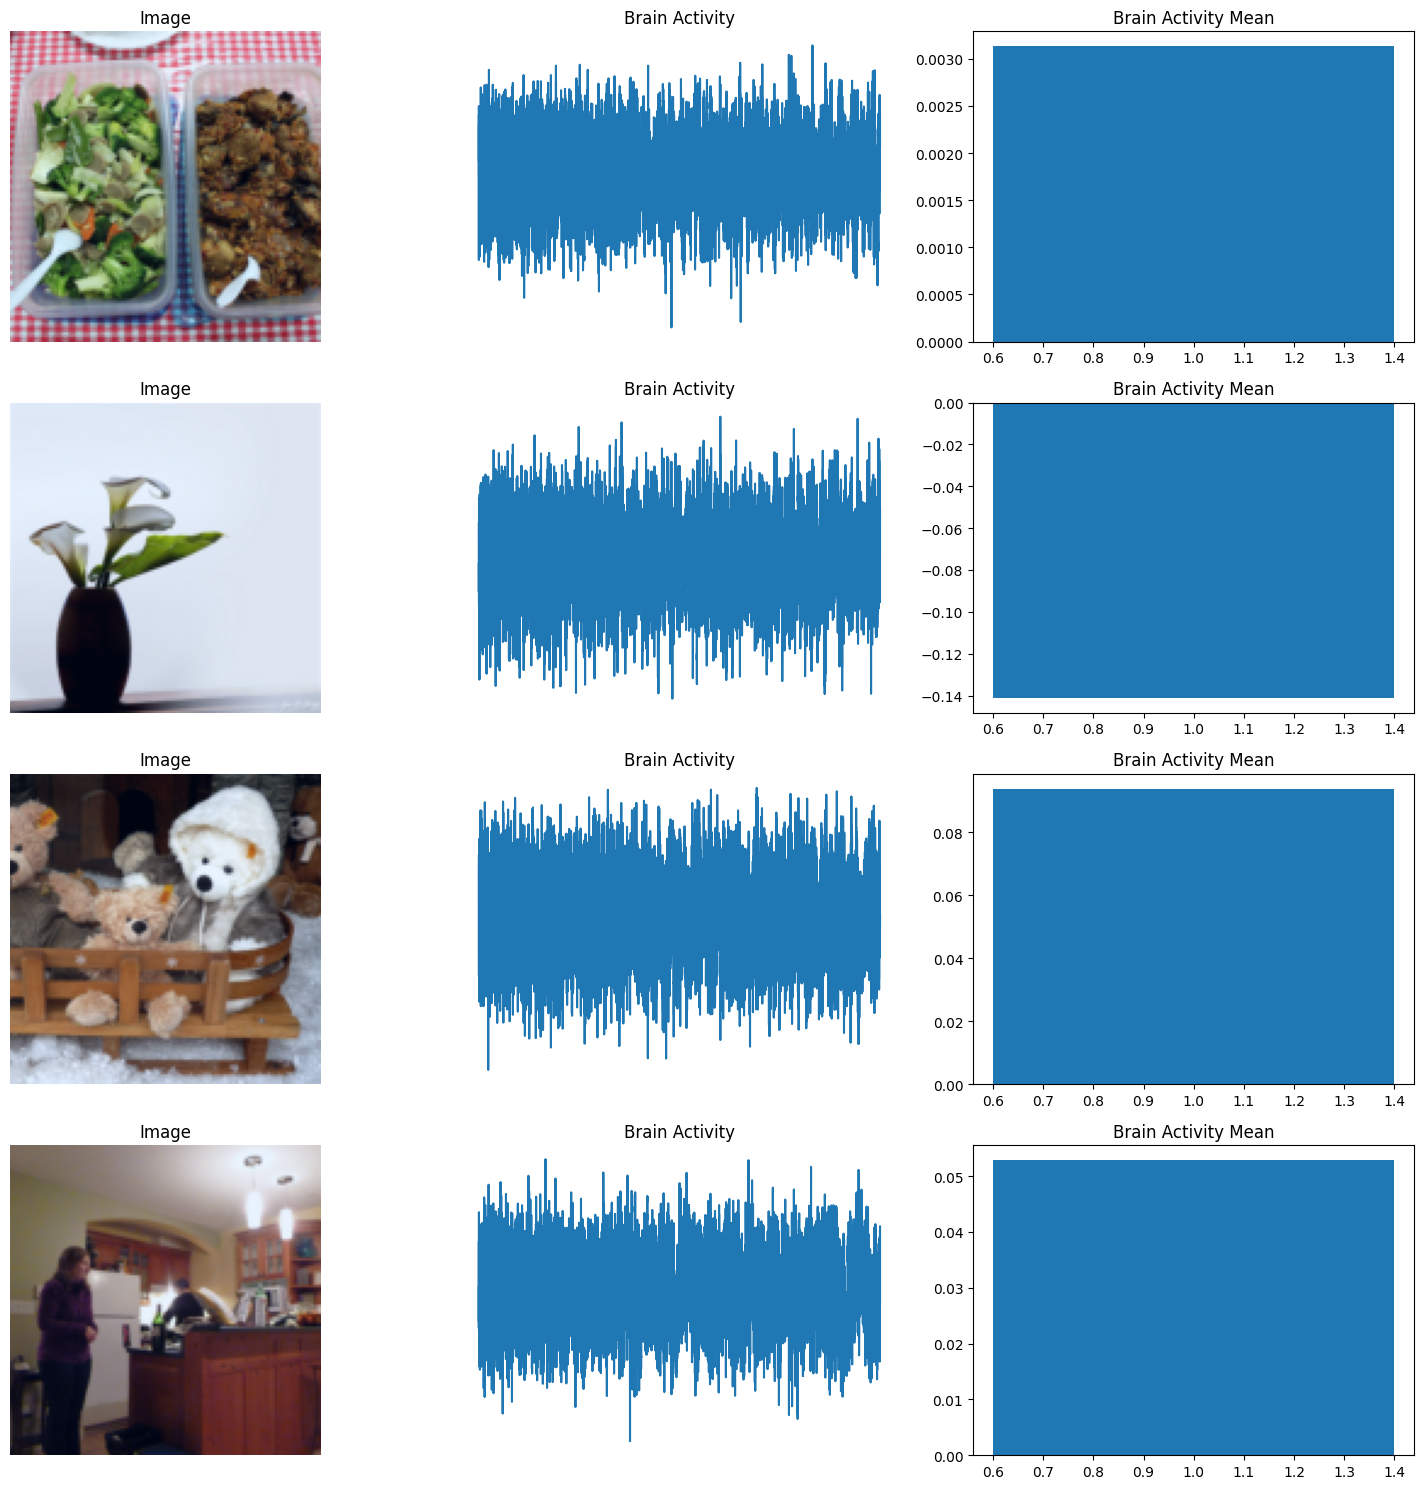

In [ ]:
image, brain_activity = next(iter(train_loader))

r = 4
fig, axs = plt.subplots(r, 3, figsize=(15, 15))
for i in range(r):
    # Show image
    showImage(axs[i, 0], image[i, :, :, :], title='Image')
    axs[i, 0].axis('off')

    # Plot brain activity
    axs[i, 1].plot(brain_activity[i,:])
    axs[i, 1].set_title('Brain Activity')
    axs[i, 1].axis('off')

    # Plot bar for mean brain activity
    m = np.mean(brain_activity[i].numpy())
    axs[i, 2].bar(1, m)
    axs[i, 2].set_title('Brain Activity Mean')

plt.tight_layout()
plt.show()

##Brain Activity Decoder

In [ ]:
class FMRI_Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FMRI_Decoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size * 8 * 8)
        self.relu = nn.ReLU()


        self.conv1 = nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=3, output_padding=1, padding=1, stride=2)
        self.conv2 = nn.ConvTranspose2d(hidden_size, hidden_size // 2, kernel_size=3, output_padding=1, padding=1, stride=2)
        self.conv3 = nn.ConvTranspose2d(hidden_size // 2, hidden_size // 4, kernel_size=3, output_padding=1, padding=1, stride=2)
        self.conv4 = nn.ConvTranspose2d(hidden_size // 4, output_size, kernel_size=3, output_padding=1, padding=1, stride=2)

    def forward(self, x):
# Encoder
        out = self.fc1(x)
        out = self.relu(out)
        out = out.reshape(out.shape[0], -1, 8, 8)


# Decoder
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.relu(out)
        out = self.conv4(out)
        out = F.tanh(out)
        return out


##Deep Learning Reconstruction Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train = False
decoder_path = '/content/drive/MyDrive/DNNLS/Assessment/fmri_decoder_subj03rhV3.pth'

checkpoint_path = '/content/drive/MyDrive/DNNLS/Assessment/fmri_decoder_subj03rhV4.pth'
image, activity = next(iter(train_loader))
size_brain_activity = activity.shape[1]
criterion = nn.MSELoss()
epochs = 90
learning_rate = 1e-3

In [ ]:
if train:
  fmri_decoder = None
  fmri_decoder = FMRI_Decoder(input_size=size_brain_activity, hidden_size=512, output_size=3)
  fmri_decoder.load_state_dict(torch.load(decoder_path,map_location=torch.device('cpu')))

  fmri_decoder.to(device)
  optimizer = torch.optim.Adam(fmri_decoder.parameters(), lr = learning_rate)
  Losses_mean = np.zeros(epochs) # We store the mean loss to plot
  Losses_std = np.zeros(epochs) # We also might want to desplay the standard deviation
  fmri_decoder.train()
  for epoch in range(epochs):
    current_losses = []
  # Set the model to training mode
    for batch_idx, (images,brain_activity) in enumerate(train_loader):
            # print('brain: ',brain_activity.shape[1])
            # print('images : ',images.shape[1])
      optimizer.zero_grad()  # Zero the gradients

      z_brain = fmri_decoder(brain_activity.to(device))  # Forward pass
      #Tensor [32 , 3 , 128,128]

      loss = criterion(z_brain, images.to(device))  # Compute the loss
      current_losses += [loss.item()]
      loss.backward()  # Backward pass
      optimizer.step()  # Update the parameters
      if np.mod(batch_idx, 500) == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item()}')

    Losses_mean[epoch] = np.mean(np.array(current_losses))
    Losses_std[epoch] = np.std(np.array(current_losses))


    # Save the trained model
    torch.save(fmri_decoder.state_dict(), checkpoint_path)
  plt.plot(Losses_mean)
  plt.axis('off')
else:
  fmri_decoder = FMRI_Decoder(input_size=size_brain_activity, hidden_size=512, output_size=3)
  fmri_decoder.load_state_dict(torch.load(decoder_path,map_location=torch.device('cpu')))
  fmri_decoder.to(device)
  fmri_decoder.eval()

##FMRI Decoder Results

###Sample images from batch

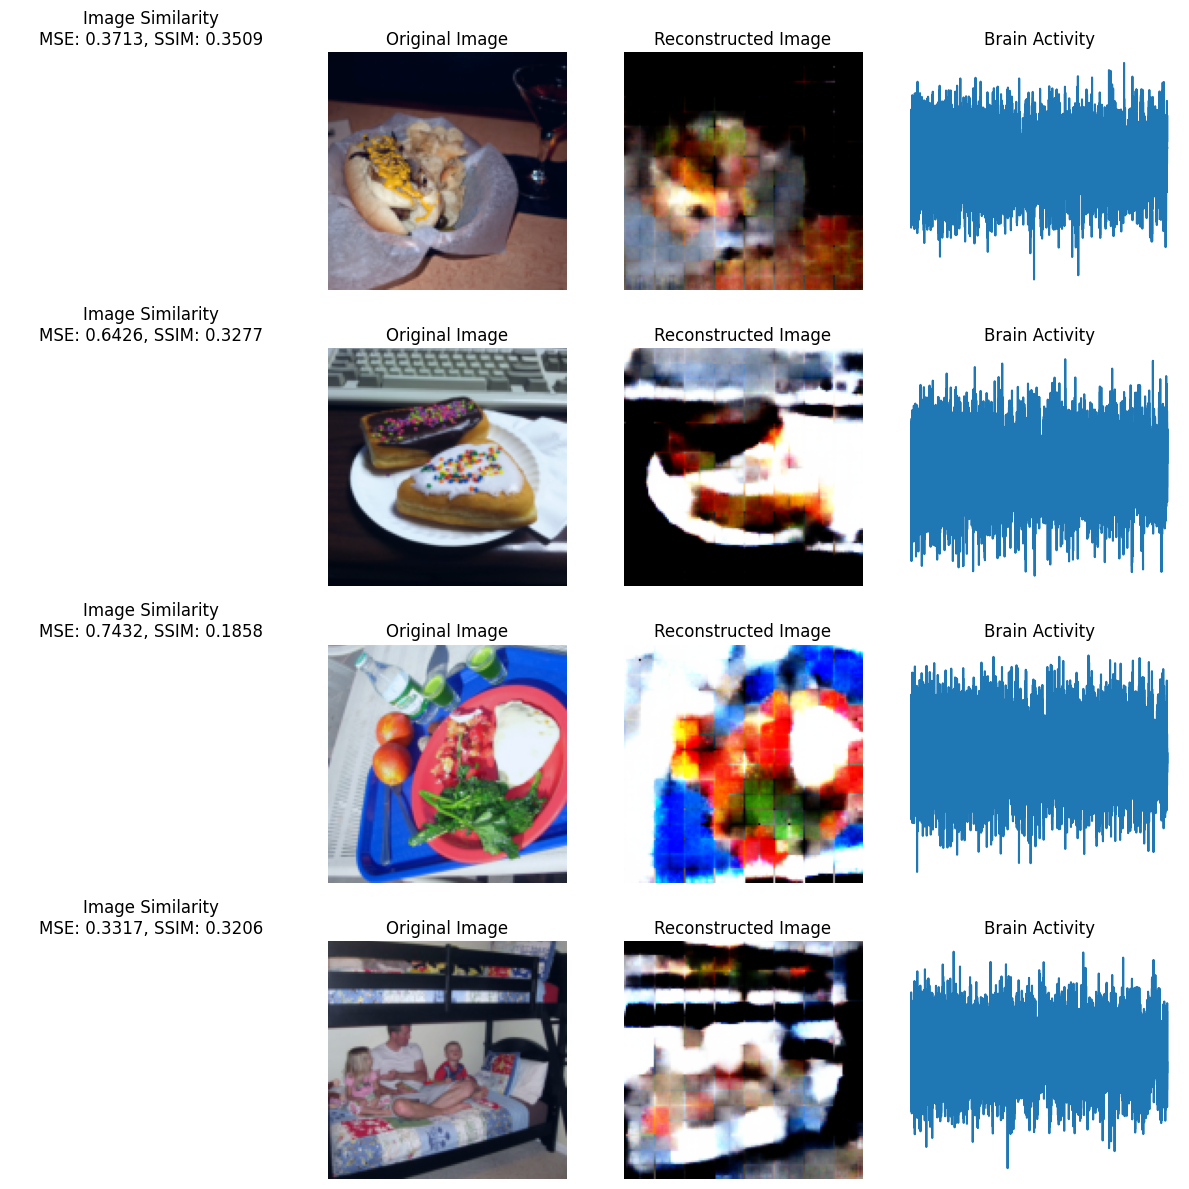

In [ ]:
test_image, test_brain_activity = next(iter(train_loader))

z_brain = fmri_decoder(test_brain_activity.to(device))
reconstructed_image = z_brain.detach().to('cpu')

r = 4
fig, axs = plt.subplots(r, 4, figsize=(12, 12))
for i in range(r):
    # Show image
    mse, ssim_value = img_similarity(test_image[i, :, :, :], reconstructed_image[i, :, :, :])
    axs[i,0].set_title(f"Image Similarity\nMSE: {mse:.4f}, SSIM: {ssim_value:.4f}")

    axs[i, 0].axis('off')
    showImage(axs[i, 1], test_image[i, :, :, :], title='Original Image')
    axs[i, 1].axis('off')

    showImage(axs[i, 2], reconstructed_image[i, :, :, :], title='Reconstructed Image')
    axs[i, 2].axis('off')
    # Plot brain activity
    axs[i, 3].plot(brain_activity[i,:])
    axs[i, 3].set_title('Brain Activity')
    axs[i, 3].axis('off')


plt.tight_layout()
plt.show()

###Best MSE score Image from the batch

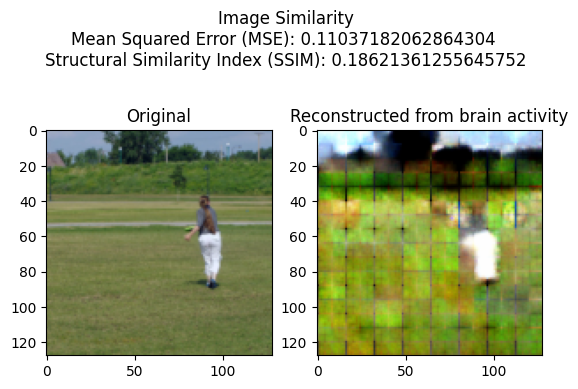

In [ ]:
best_qimg = None
best_mse = 1.0
best_ssim = 0.0

for i in range(32):
    mse, ssim_value = img_similarity(test_image[i, :, :, :], reconstructed_image[i, :, :, :])
    if best_mse > mse:  # Check if current image has lower MSE
        best_qimg = i
        best_mse = mse
        best_ssim = ssim_value

fig, ax = plt.subplots(1, 2)
showImage(ax[0], test_image[best_qimg, :, :, :], title='Original')
showImage(ax[1], reconstructed_image[best_qimg, :, :, :], title='Reconstructed from brain activity')
fig.suptitle(f"Image Similarity\nMean Squared Error (MSE): {best_mse} \nStructural Similarity Index (SSIM): {best_ssim}")
plt.show()


###Best SSIM score Image from the batch

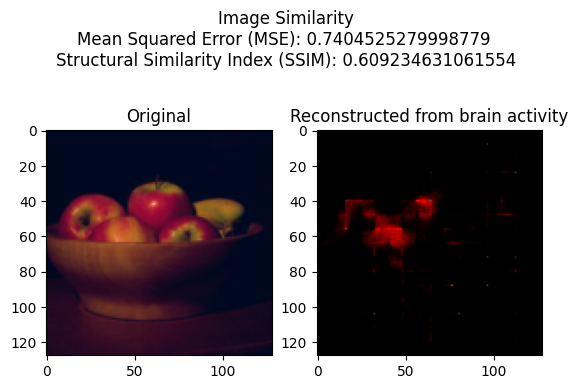

In [ ]:

best_qimg = None
best_mse = 1.0
best_ssim = 0.0

for i in range(32):
    mse, ssim_value = img_similarity(test_image[i, :, :, :], reconstructed_image[i, :, :, :])
    if ssim_value > best_ssim:  # Check if current image has lower MSE
        best_qimg = i
        best_mse = mse
        best_ssim = ssim_value

fig, ax = plt.subplots(1, 2)
showImage(ax[0], test_image[best_qimg, :, :, :], title='Original')
showImage(ax[1], reconstructed_image[best_qimg, :, :, :], title='Reconstructed from brain activity')
fig.suptitle(f"Image Similarity\nMean Squared Error (MSE): {best_mse} \nStructural Similarity Index (SSIM): {best_ssim}")
plt.show()


In [ ]:
  fmri_decoder.eval()

FMRI_Decoder(
  (fc1): Linear(in_features=20544, out_features=32768, bias=True)
  (relu): ReLU()
  (conv1): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv2): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv4): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)